## <b>GAN model for predicting SBUX price

### 1.) Import necessary libraries

In [18]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas_ta
import datetime as dt
import re
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import warnings
warnings.filterwarnings('ignore')

### 2.) Collecting data

In [19]:
starbuck_fin = pd.read_csv('starbuck.csv')
starbuck_fin.head()

,Date,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,MACD,rsi
0,2013-01-02,27.500000,0.017091,185.981818,0.022074,0.003807,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,100.000000
1,2013-01-03,27.684999,0.016977,184.739032,0.021927,0.003781,161.199997,92.919998,1459.369995,2732.260010,0.17,0.004151,100.000000
2,2013-01-04,27.844999,0.016879,183.677505,0.021801,0.003759,160.440002,93.089996,1466.469971,2724.489990,0.16,0.010250,100.000000
3,2013-01-07,27.860001,0.016870,183.578603,0.021789,0.003757,159.429993,93.190002,1461.890015,2724.219971,0.16,0.013315,100.000000
4,2013-01-08,27.809999,0.016900,183.908669,0.021828,0.003764,160.559998,93.150002,1457.150024,2718.719971,0.15,0.012710,87.804651


In [20]:
# calculate sma
starbuck_fin['SMA21'] = starbuck_fin['Close'].rolling(window = 21).mean()

# calculate bband
window_size = 20
num_std_dev = 2
rolling_mean = starbuck_fin['Close'].rolling(window = window_size).mean()
rolling_std = starbuck_fin['Close'].rolling(window = window_size).std()

starbuck_fin['bbupper'] = rolling_mean + (num_std_dev * rolling_std)
starbuck_fin['bblower'] = rolling_mean - (num_std_dev * rolling_std)

starbuck_fin.bfill(inplace=True)
display(starbuck_fin.head())

starbuck_fin.to_csv('starbuck_final_2.csv')

,Date,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,MACD,rsi,SMA21,bbupper,bblower
0,2013-01-02,27.500000,0.017091,185.981818,0.022074,0.003807,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,100.000000,27.594286,28.247762,26.894238
1,2013-01-03,27.684999,0.016977,184.739032,0.021927,0.003781,161.199997,92.919998,1459.369995,2732.260010,0.17,0.004151,100.000000,27.594286,28.247762,26.894238
2,2013-01-04,27.844999,0.016879,183.677505,0.021801,0.003759,160.440002,93.089996,1466.469971,2724.489990,0.16,0.010250,100.000000,27.594286,28.247762,26.894238
3,2013-01-07,27.860001,0.016870,183.578603,0.021789,0.003757,159.429993,93.190002,1461.890015,2724.219971,0.16,0.013315,100.000000,27.594286,28.247762,26.894238
4,2013-01-08,27.809999,0.016900,183.908669,0.021828,0.003764,160.559998,93.150002,1457.150024,2718.719971,0.15,0.012710,87.804651,27.594286,28.247762,26.894238


### 3.) Data preprocessing

In [22]:
# 3.1) import libraries

import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

starbuck_fin['Date'] = pd.to_datetime(starbuck_fin['Date'])
starbuck_fin.set_index('Date', inplace=True)
display(starbuck_fin.head())
display(starbuck_fin.shape)

,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,MACD,rsi,SMA21,bbupper,bblower
Date,,,,,,,,,,,,,,,
2013-01-02,27.500000,0.017091,185.981818,0.022074,0.003807,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,100.000000,27.594286,28.247762,26.894238
2013-01-03,27.684999,0.016977,184.739032,0.021927,0.003781,161.199997,92.919998,1459.369995,2732.260010,0.17,0.004151,100.000000,27.594286,28.247762,26.894238
2013-01-04,27.844999,0.016879,183.677505,0.021801,0.003759,160.440002,93.089996,1466.469971,2724.489990,0.16,0.010250,100.000000,27.594286,28.247762,26.894238
2013-01-07,27.860001,0.016870,183.578603,0.021789,0.003757,159.429993,93.190002,1461.890015,2724.219971,0.16,0.013315,100.000000,27.594286,28.247762,26.894238
2013-01-08,27.809999,0.016900,183.908669,0.021828,0.003764,160.559998,93.150002,1457.150024,2718.719971,0.15,0.012710,87.804651,27.594286,28.247762,26.894238


(2506, 15)

In [23]:
display(starbuck_fin.shape)

(2506, 15)

In [24]:
# 3.2) specifying x and y

X_value = pd.DataFrame(starbuck_fin.iloc[:, :])
y_value = pd.DataFrame(starbuck_fin.iloc[:, 0])

In [26]:
display(X_value.shape)
display(y_value.shape)

(2506, 15)

(2506, 1)

In [25]:
# 3.3) Normalized the data

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [30]:
display(X_scale_dataset.shape)
display(y_scale_dataset.shape)

(2506, 15)

(2506, 1)

In [31]:
# 3.4) function for reshaping data / getting index of training and testing
# and spliting train and test dataset

n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [32]:
# 3.5) getting data and checking for shape

X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(starbuck_fin, X_train, n_steps_in, n_steps_out)

In [41]:
display(X.shape)
display(y.shape)

(2503, 3, 15)

(2503, 1)

In [33]:
# 3.6) show data's shape and save

print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)

X shape:  (2503, 3, 15)
y shape:  (2503, 1)
X_train shape:  (1752, 3, 15)
y_train shape:  (1752, 1)
y_c_train shape:  (1752, 3, 1)
X_test shape:  (751, 3, 15)
y_test shape:  (751, 1)
y_c_test shape:  (751, 3, 1)
index_train shape: (1752,)
index_test shape: (751,)


### 4.) GAN framework - training model

In [11]:
# 4.1) import libraries

import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

In [12]:
# 4.2) import data

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [13]:
# 4.3) function for generator, discriminator and GAN

def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)

epoch 15 d_loss 1.0184133 g_loss 1.3679713


epoch 30 d_loss 1.3817677 g_loss 0.7029018


epoch 45 d_loss 1.38237 g_loss 0.6855193


epoch 60 d_loss 1.3854188 g_loss 0.6913346


epoch 75 d_loss 1.3863121 g_loss 0.6907255


epoch 90 d_loss 1.3857939 g_loss 0.6935238


epoch 105 d_loss 1.3863478 g_loss 0.6932734


epoch 120 d_loss 1.3853238 g_loss 0.69355226


epoch 135 d_loss 1.3833674 g_loss 0.6884682


epoch 150 d_loss 1.3707049 g_loss 0.71474123


epoch 165 d_loss 1.3292518 g_loss 0.7246356


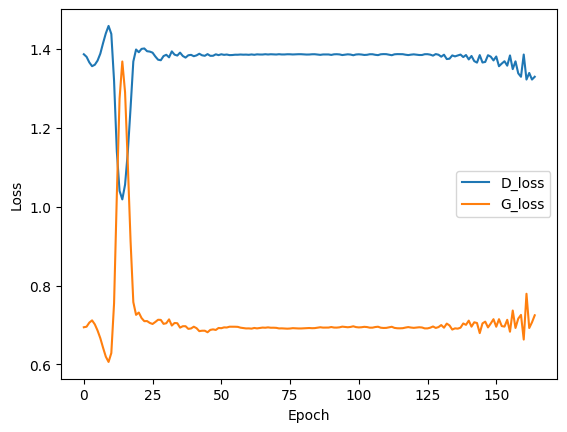

In [14]:
# 4.4) training model

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

## For Bayesian
opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator, opt)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

### 6.) GAN framework - checking RSME for training set

In [15]:
RMSE_training = {}

models = [
    'gen_model_3_1_14.h5',
    'gen_model_3_1_29.h5',
    'gen_model_3_1_44.h5',
    'gen_model_3_1_59.h5',
    'gen_model_3_1_74.h5',
    'gen_model_3_1_89.h5',
    'gen_model_3_1_104.h5',
    'gen_model_3_1_119.h5',
    'gen_model_3_1_134.h5',
    'gen_model_3_1_149.h5',
    'gen_model_3_1_164.h5'
]



def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    # plt.figure(figsize=(16, 8))
    # plt.plot(real_price["real_mean"])
    # plt.plot(predict_result["predicted_mean"], color='r')
    # plt.xlabel("Date")
    # plt.ylabel("Stock price")
    # plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    # plt.title("The result of test", fontsize=20)
    # plt.show()
    # plt.savefig('test_plot.png')

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

# Load test dataset/ 

for model in models:
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)
    test_predict_index = np.load("index_test.npy", allow_pickle=True)
    G_model = tf.keras.models.load_model(model)
    X_test = np.load("X_train.npy", allow_pickle=True)
    y_test = np.load("y_train.npy", allow_pickle=True)
    test_predicted, test_RMSE = get_test_plot(X_test, y_test)
    RMSE_training[model] = test_RMSE

print(RMSE_training)

-- RMSE --  525.1396385000236


-- RMSE --  14.145344654488328


-- RMSE --  1.7973926621638134


-- RMSE --  2.1391396416006954


-- RMSE --  1.3117832196307926


-- RMSE --  1.9658408113530106


-- RMSE --  1.2730910627483683


-- RMSE --  1.2723341088014704


-- RMSE --  3.104835988815862


-- RMSE --  1.7735019287252198


-- RMSE --  2.8535234540157477
{'gen_model_3_1_14.h5': 525.1396385000236, 'gen_model_3_1_29.h5': 14.145344654488328, 'gen_model_3_1_44.h5': 1.7973926621638134, 'gen_model_3_1_59.h5': 2.1391396416006954, 'gen_model_3_1_74.h5': 1.3117832196307926, 'gen_model_3_1_89.h5': 1.9658408113530106, 'gen_model_3_1_104.h5': 1.2730910627483683, 'gen_model_3_1_119.h5': 1.2723341088014704, 'gen_model_3_1_134.h5': 3.104835988815862, 'gen_model_3_1_149.h5': 1.7735019287252198, 'gen_model_3_1_164.h5': 2.8535234540157477}


### 5.) GAN framework - checking RMSE for testing set

In [16]:
RMSE_testing = {}

models = [
    'gen_model_3_1_14.h5',
    'gen_model_3_1_29.h5',
    'gen_model_3_1_44.h5',
    'gen_model_3_1_59.h5',
    'gen_model_3_1_74.h5',
    'gen_model_3_1_89.h5',
    'gen_model_3_1_104.h5',
    'gen_model_3_1_119.h5',
    'gen_model_3_1_134.h5',
    'gen_model_3_1_149.h5',
    'gen_model_3_1_164.h5'
]

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    # plt.figure(figsize=(16, 8))
    # plt.plot(real_price["real_mean"])
    # plt.plot(predict_result["predicted_mean"], color='r')
    # plt.xlabel("Date")
    # plt.ylabel("Stock price")
    # plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    # plt.title("The result of test", fontsize=20)
    # plt.show()
    # plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE


# Load scaler/ index
for model in models:
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)
    test_predict_index = np.load("index_test.npy", allow_pickle=True)
    G_model = tf.keras.models.load_model(model)
    X_test = np.load("X_test.npy", allow_pickle=True)
    y_test = np.load("y_test.npy", allow_pickle=True)
    test_predicted, test_RMSE = get_test_plot(X_test, y_test)
    # test_predicted.to_csv("test_predicted.csv")
    RMSE_testing[model] = test_RMSE

-- RMSE --  177.31940374079315


-- RMSE --  7.3345680702157265


-- RMSE --  5.789109806768271


-- RMSE --  4.051006511709676


-- RMSE --  3.3493332783213225


-- RMSE --  6.040189185838509


-- RMSE --  3.8905658730626898


-- RMSE --  3.0143729279591334


-- RMSE --  3.0322689863928045


-- RMSE --  3.0396565172878494


-- RMSE --  3.46686035506207


### 6.) Comparing Result and select the right model

In [27]:
RMSE_data = {'Training' : pd.Series(RMSE_training).values, 'Testing' : pd.Series(RMSE_testing).values}
RMSE_index = pd.Series(RMSE_testing).index
RMSE_all_model = pd.DataFrame(RMSE_data, RMSE_index)
display(RMSE_all_model)

,Training,Testing
gen_model_3_1_14.h5,525.139639,177.319404
gen_model_3_1_29.h5,14.145345,7.334568
gen_model_3_1_44.h5,1.797393,5.789110
gen_model_3_1_59.h5,2.139140,4.051007
gen_model_3_1_74.h5,1.311783,3.349333
gen_model_3_1_89.h5,1.965841,6.040189
gen_model_3_1_104.h5,1.273091,3.890566
gen_model_3_1_119.h5,1.272334,3.014373
gen_model_3_1_134.h5,3.104836,3.032269
gen_model_3_1_149.h5,1.773502,3.039657


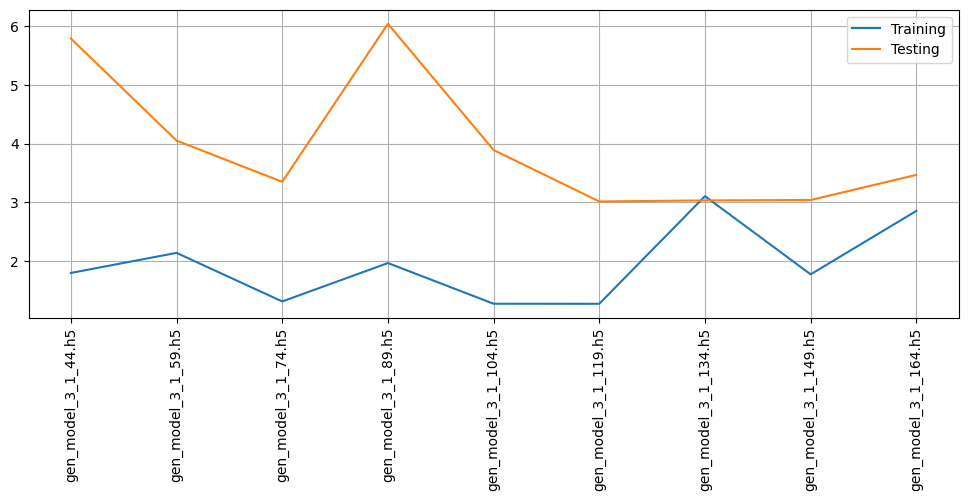

In [41]:
RMSE_all_model[['Training','Testing']].iloc[2:,:].plot(figsize = (12,4))
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### 7.) Visualize training set of model having epoch = 120

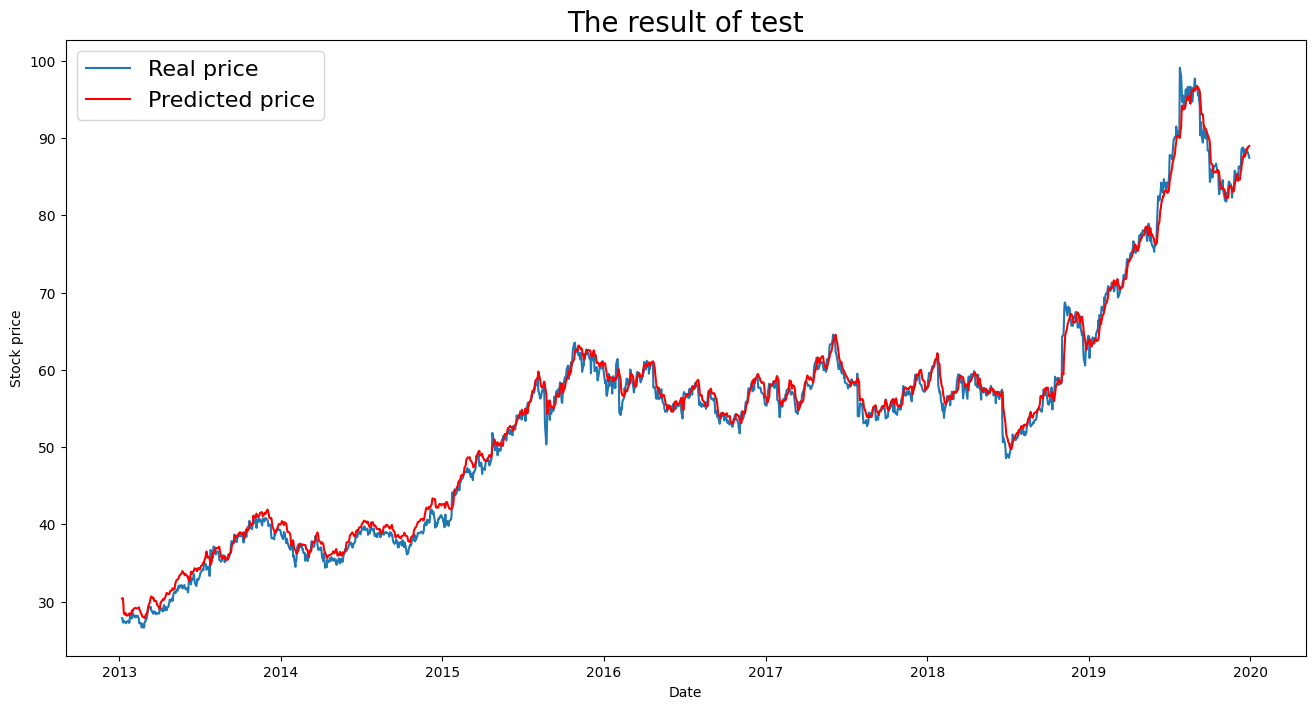

-- RMSE --  1.2723341088014704
-- MAE -- 0.9515220432893498
-- MAPE -- 0.019404412181596494
-- MSLE -- 0.0006287480839671952
--R2 -- 0.9930464645084807


<Figure size 640x480 with 0 Axes>

In [52]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# def mean_absolute_percentage_error(actual, predicted):
#     actual, predicted = np.array(actual), np.array(predicted)
#     nonzero_elements = actual != 0
#     mape = np.mean(np.abs((actual - predicted) / actual[nonzero_elements])) * 100
#     return mape

# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_119.h5')
X_test = np.load("X_train.npy", allow_pickle=True)
y_test = np.load("y_train.npy", allow_pickle=True)


def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE = mean_absolute_error(real, predicted)
    MAPE = mean_absolute_percentage_error(real, predicted)
    MSLE = mean_squared_log_error(real, predicted)
    r2 = r2_score(real, predicted)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    print('-- MAPE --', MAPE)
    print('-- MSLE --', MSLE)
    print('--R2 --', r2)
    return predict_result, RMSE


train_predicted, test_RMSE = get_test_plot(X_test, y_test)

### 8.) Visualize testing set of model having epoch = 120

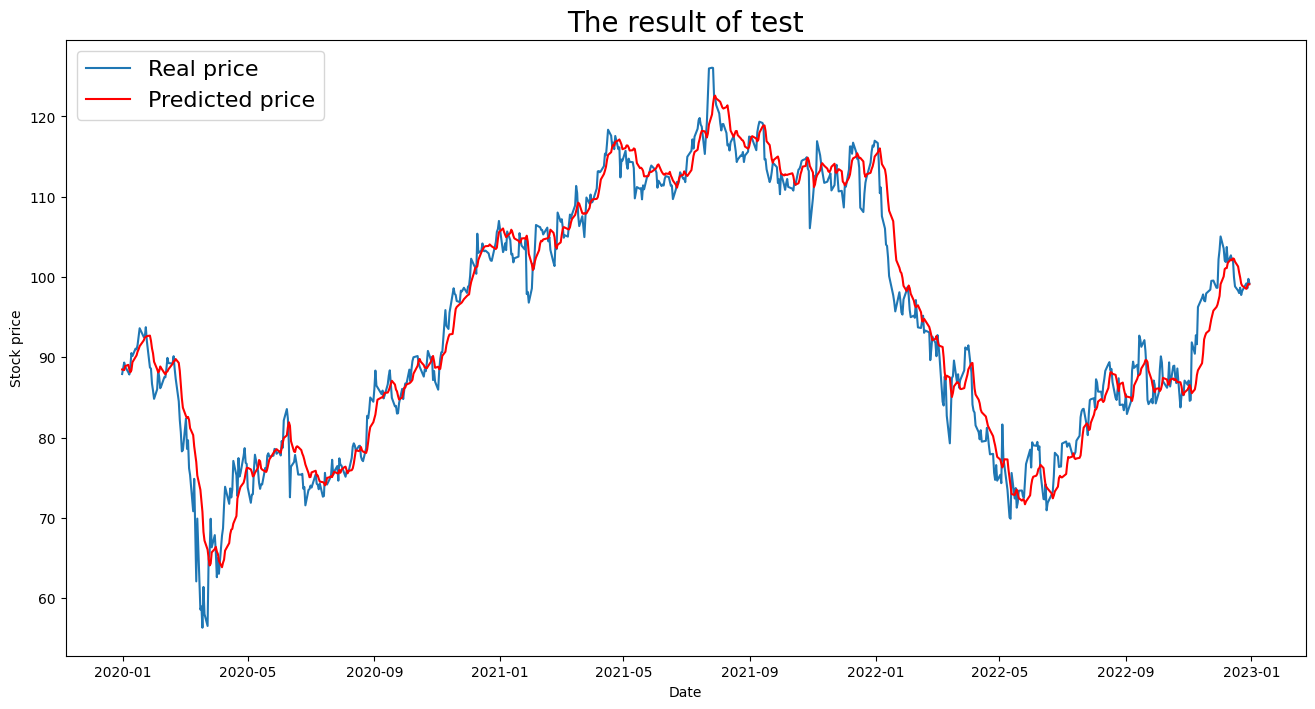

-- RMSE --  3.0143729279591334
-- MAE -- 2.203225902131978
-- MAPE -- 0.024957302356494945
-- MSLE -- 0.0012699153155134458
--R2 -- 0.961814403559674


<Figure size 640x480 with 0 Axes>

In [56]:
# Load scaler/ index
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# def mean_absolute_percentage_error(actual, predicted):
#     actual, predicted = np.array(actual), np.array(predicted)
#     nonzero_elements = actual != 0
#     mape = np.mean(np.abs((actual - predicted) / actual[nonzero_elements])) * 100
#     return mape

X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_119.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)


def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE = mean_absolute_error(real, predicted)
    MAPE = mean_absolute_percentage_error(real, predicted)
    MSLE = mean_squared_log_error(real, predicted)
    r2 = r2_score(real, predicted)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    print('-- MAPE --', MAPE)
    print('-- MSLE --', MSLE)
    print('--R2 --', r2)

    return predict_result, RMSE


test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted_final.csv")

### 9.) Constructing Trading Strategy

In [116]:
# 9.1) create the training set's predicted price dataframe

train_predicted_price = pd.DataFrame(train_predicted.iloc[:,-1])
train_predicted_price.rename(columns={'predicted_mean':'predicted_price'},inplace=True)
display(train_predicted_price.head(3))
display(train_predicted_price.tail(3))

,predicted_price
2013-01-07,30.380041
2013-01-08,30.451120
2013-01-09,30.390572


,predicted_price
2019-12-26,88.625024
2019-12-27,88.824046
2019-12-30,88.991916


In [117]:
# 9.2) create the testing set's predicted price dataframe

test_predicted_price = pd.DataFrame(test_predicted.iloc[:,-1])
test_predicted_price.rename(columns={'predicted_mean':'predicted_price'},inplace=True)
display(test_predicted_price.head(3))
display(test_predicted_price.tail(3))

,predicted_price
2019-12-31,88.483966
2020-01-02,88.407876
2020-01-03,88.908201


,predicted_price
2022-12-28,98.857334
2022-12-29,99.148055
2022-12-30,99.095950


In [118]:
# 9.3 create dataframe for constructing strategy

training_strategy = pd.DataFrame(starbuck_fin['Close'].filter(items = index_train, axis = 0))
print('for training :')
training_strategy['predicted_price'] = train_predicted_price.values
display(training_strategy.head(3))
display(training_strategy.tail(3))

testing_strategy = pd.DataFrame(starbuck_fin['Close'].filter(items = index_test, axis = 0))
print('for testing :')
testing_strategy['predicted_price'] = test_predicted_price.values
display(testing_strategy.head(3))
display(testing_strategy.tail(3))

for training :


,Close,predicted_price
Date,,
2013-01-07,27.860001,30.380041
2013-01-08,27.809999,30.451120
2013-01-09,27.315001,30.390572


,Close,predicted_price
Date,,
2019-12-26,88.080002,88.625024
2019-12-27,88.129997,88.824046
2019-12-30,87.440002,88.991916


for testing :


,Close,predicted_price
Date,,
2019-12-31,87.919998,88.483966
2020-01-02,89.349998,88.407876
2020-01-03,88.830002,88.908201


,Close,predicted_price
Date,,
2022-12-28,98.599998,98.857334
2022-12-29,99.769997,99.148055
2022-12-30,99.199997,99.095950


In [119]:
# 9.4 calculate normal return and log return of SBUX

def calculate_returns(df):
    df['normal_return'] = df['Close'].pct_change()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['cumulative_return'] = df[['log_return']].cumsum().apply(np.exp)
    return df

training_strategy = calculate_returns(training_strategy)
testing_strategy = calculate_returns(testing_strategy)


In [120]:
# 9.5 display the final dataframes

display(training_strategy.head())
display(testing_strategy.head())

,Close,predicted_price,normal_return,log_return,cumulative_return
Date,,,,,
2013-01-07,27.860001,30.380041,NaN,NaN,NaN
2013-01-08,27.809999,30.451120,-0.001795,-0.001796,0.998205
2013-01-09,27.315001,30.390572,-0.017799,-0.017960,0.980438
2013-01-10,27.270000,29.717153,-0.001647,-0.001649,0.978823
2013-01-11,27.504999,28.475387,0.008617,0.008581,0.987258


,Close,predicted_price,normal_return,log_return,cumulative_return
Date,,,,,
2019-12-31,87.919998,88.483966,NaN,NaN,NaN
2020-01-02,89.349998,88.407876,0.016265,0.016134,1.016265
2020-01-03,88.830002,88.908201,-0.005820,-0.005837,1.010350
2020-01-06,88.129997,89.061439,-0.007880,-0.007911,1.002389
2020-01-07,87.860001,88.495842,-0.003064,-0.003068,0.999318


> <b>9.6) Naive condition</b>\
> Long : The predicted price is higher than the closing price of today\
> Short : The predicted price is lower than the closing price of today

In [122]:
# 9.6.1 create function for strategy return

def naive_strategy(df):
    df['position'] = np.nan
    df['position'] = np.where(df['predicted_price'] > df['Close'], 1, -1)
    df['strategy_return'] = df['position'].shift(1) * df['log_return']
    df['cumulative_strategy_return'] = df['strategy_return'].cumsum().apply(np.exp)
    return df

training_strategy = naive_strategy(training_strategy)
testing_strategy = naive_strategy(testing_strategy)

print('for training :')
display(training_strategy.tail())

print('for testing :')
display(testing_strategy.tail())

for training :


,Close,predicted_price,normal_return,log_return,cumulative_return,position,strategy_return,cumulative_strategy_return
Date,,,,,,,,
2019-12-23,88.230003,88.206825,-0.002600,-0.002603,3.166906,-1,0.002603,4.065858
2019-12-24,88.519997,88.632029,0.003287,0.003281,3.177315,1,-0.003281,4.052538
2019-12-26,88.080002,88.625024,-0.004971,-0.004983,3.161522,1,-0.004983,4.032395
2019-12-27,88.129997,88.824046,0.000568,0.000567,3.163316,1,0.000567,4.034684
2019-12-30,87.440002,88.991916,-0.007829,-0.007860,3.138550,1,-0.007860,4.003095


for testing :


,Close,predicted_price,normal_return,log_return,cumulative_return,position,strategy_return,cumulative_strategy_return
Date,,,,,,,,
2022-12-23,98.269997,98.909798,0.005217,0.005203,1.117721,1,0.005203,1.592417
2022-12-27,99.199997,98.525787,0.009464,0.009419,1.128298,-1,0.009419,1.607487
2022-12-28,98.599998,98.857334,-0.006048,-0.006067,1.121474,1,0.006067,1.617269
2022-12-29,99.769997,99.148055,0.011866,0.011796,1.134782,-1,0.011796,1.636459
2022-12-30,99.199997,99.095950,-0.005713,-0.005730,1.128298,-1,0.005730,1.645862


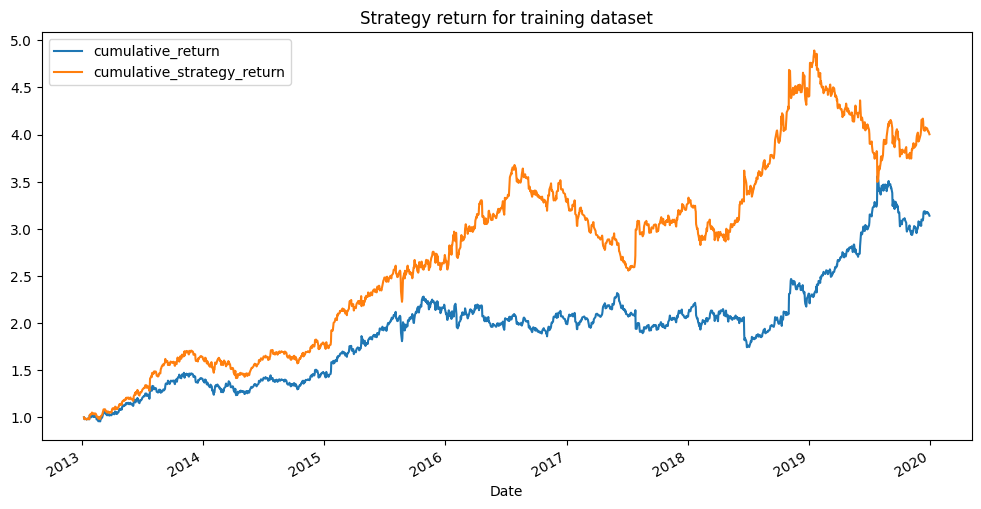

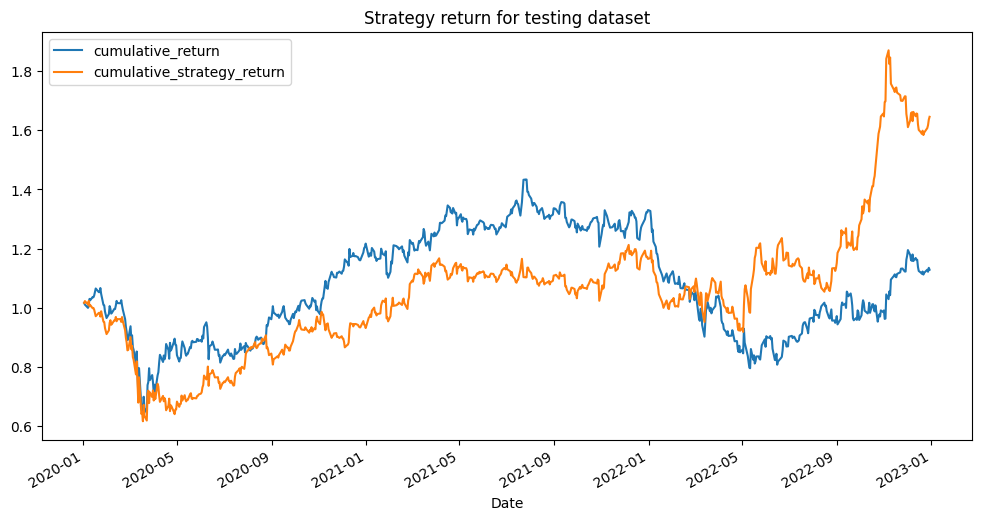

In [127]:
# 9.6.2) visualize the result

training_strategy[['cumulative_return','cumulative_strategy_return']].plot(figsize = (12,6))
plt.title('Strategy return for training dataset')
plt.show()
testing_strategy[['cumulative_return','cumulative_strategy_return']].plot(figsize = (12,6))
plt.title('Strategy return for testing dataset')
plt.show()

In [134]:
# 9.6.3) calculate CAGR (Compound annual growth rate)

days = (starbuck_fin.index[-1] - starbuck_fin.index[0]).days
cagr_BH_train = (((training_strategy['cumulative_return'][-1]/ training_strategy['cumulative_return'][1]))**(365 / days))-1
cagr_ML_train = (((training_strategy['cumulative_strategy_return'][-1]/ training_strategy['cumulative_strategy_return'][1]))**(365 / days))-1
cagr_BH_test = (((testing_strategy['cumulative_return'][-1]/ testing_strategy['cumulative_return'][1]))**(365 / days))-1
cagr_ML_test = (((testing_strategy['cumulative_strategy_return'][-1]/ testing_strategy['cumulative_strategy_return'][1]))**(365 / days))-1

print('For training set :')
print('CAGR of buy and hold from 2013 to end of 2019 is {:.5f}'.format(cagr_BH_train))
print('CAGR of our strategy from 2013 to end of 2019 is {:.5f}'.format(cagr_ML_train))
print(' ')
print('For testing set :')
print('CAGR of buy and hold from 2020 to end of 2022 is {:.5f}'.format(cagr_BH_test))
print('CAGR of our strategy from 2020 to end of 2022 is {:.5f}'.format(cagr_ML_test))

For training set :
CAGR of buy and hold from 2013 to end of 2019 is 0.12141
CAGR of our strategy from 2013 to end of 2019 is 0.14904
 
For testing set :
CAGR of buy and hold from 2020 to end of 2022 is 0.01052
CAGR of our strategy from 2020 to end of 2022 is 0.04941
